In [1]:
import pandas     as pd
import tensorflow as tf
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from typing import Any, Tuple
from scipy import interpolate 
from copy import deepcopy

2024-03-07 18:40:22.708313: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 18:40:22.755764: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 18:40:22.755823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 18:40:22.757088: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 18:40:22.764731: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 18:40:22.765466: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
TESTING_WINDOW_SIZES = ['10min']
DATA_FOLDER          = './datasets/ambient_measurements/2022'
DATA_FILENAMES       = ['hum.csv', 'temp.csv']
VARIABLE_NAMES       = ['hum_level', 'temp_level']
PREFER_MAE_OVER_MSE  = False

SPLIT_DATE           = '2022-05-29 00:00:00'
INTERPOLATION_METHOD = 'linear'
INTERPOLATION_ORDER  = 3
RESAMPLE_FREQ        = '5min'

#MODEL PARAMETERS
PATIENCE             = 10
EPOCHS               = 100
WINDOW_SIZE          = 24 #keep in mind that each data point is 5 minutes apart
BATCH_SIZE           = 32 
TIMESTEPS_AHEAD      = 36 #keep in mind that each data point is 5 minutes apart
SHUFFLE_BUFFER_SIZE  = 1000

In [3]:
data = pd.read_csv(f"{DATA_FOLDER}/{DATA_FILENAMES[0]}", index_col=0, parse_dates=True)
data.head()

,hum_level
time,
2022-05-09 21:22:18,50.23
2022-05-09 21:24:48,50.30
2022-05-09 21:27:18,50.33
2022-05-09 21:32:18,50.37
2022-05-09 21:37:18,50.41


# Resample and Interpolate 

This is done to make the model more resilient to periods of time where there is no data. This is done by resampling the data to a fixed frequency and then interpolating the missing values.

In [4]:
data = data.interpolate(method=INTERPOLATION_METHOD, order=INTERPOLATION_ORDER).\
            resample(RESAMPLE_FREQ).mean().interpolate(method=INTERPOLATION_METHOD, order=INTERPOLATION_ORDER)

# Splitting the data

In [5]:
# Split the data into training and testing sets
train = deepcopy(data[:SPLIT_DATE])
test = deepcopy(data[SPLIT_DATE:])

# Plot the data
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train[VARIABLE_NAMES[0]], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=test.index, y=test[VARIABLE_NAMES[0]], mode='lines', name='Test'))
fig.update_layout(title='Humidity', xaxis_title='Time', yaxis_title='Humidity')
fig.show()

# Prepare the data for training and testing

After the data has been resampled, interpolated, it is split into training and testing data. The training data is used to train the model and the testing data is used to evaluate the model.

In [6]:
def windowed_dataset(series: np.array,
                     window_size: int,
                     batch_size: int,
                     shuffle_buffer: int,
                     timesteps_ahead: int = 12, 
                     shuffle: bool = True) -> tf.data.Dataset:

    """
    Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int)       - the number of time steps to average
      batch_size (int)        - the batch size
      timestep_ahead (int)    - the number of time steps to predict
      shuffle_buffer(int)     - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + timesteps_ahead, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + timesteps_ahead))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-timesteps_ahead], window[-timesteps_ahead:]))

    # Shuffle the windows
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [7]:
train_dataset = windowed_dataset(train[VARIABLE_NAMES[0]], WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, TIMESTEPS_AHEAD)
test_dataset = windowed_dataset(test[VARIABLE_NAMES[0]], WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, TIMESTEPS_AHEAD, shuffle=False)

In [8]:
# Print properties of a single batch
for windows in train_dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 24)
shape of second element: (32, 36)


# Build the baseline model

In [9]:
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[WINDOW_SIZE]),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(TIMESTEPS_AHEAD),
])

model_baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                250       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 36)                396       
                                                                 
Total params: 756 (2.95 KB)
Trainable params: 756 (2.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
model_baseline.compile(loss      = tf.losses.MeanSquaredError(),
                       optimizer = "adam",
                       metrics   = ["mae", "mse"])

#patience callback of 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, mode='min')

# Train the model and save the history
history = model_baseline.fit(train_dataset,
                             epochs=EPOCHS,
                             validation_data=test_dataset,
                             callbacks=[early_stopping])

Epoch 1/100
171/171 [==============================] - 2s 8ms/step - loss: 1547.8103 - mae: 34.8416 - mse: 1547.8103 - val_loss: 442.8762 - val_mae: 18.5116 - val_mse: 442.8762
Epoch 2/100
171/171 [==============================] - 1s 6ms/step - loss: 682.1747 - mae: 19.6499 - mse: 682.1747 - val_loss: 198.8878 - val_mae: 13.7911 - val_mse: 198.8878
Epoch 3/100
171/171 [==============================] - 1s 6ms/step - loss: 598.1390 - mae: 18.0288 - mse: 598.1390 - val_loss: 183.1339 - val_mae: 13.3875 - val_mse: 183.1339
Epoch 4/100
171/171 [==============================] - 1s 6ms/step - loss: 560.4242 - mae: 17.4484 - mse: 560.4242 - val_loss: 160.5486 - val_mae: 12.5370 - val_mse: 160.5486
Epoch 5/100
171/171 [==============================] - 1s 6ms/step - loss: 499.6686 - mae: 16.4545 - mse: 499.6686 - val_loss: 141.0378 - val_mae: 11.7389 - val_mse: 141.0378
Epoch 6/100
171/171 [==============================] - 1s 6ms/step - loss: 486.1743 - mae: 16.3623 - mse: 486.1743 - val_lo

In [11]:
# Plot the loss and the MAE
fig = go.Figure()
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], mode='lines', name='Test'))
fig.update_layout(title='Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

In [12]:
type(test_dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [29]:
baseline_eval = model_baseline.evaluate(test_dataset)

      1/Unknown - 0s 43ms/step - loss: 128.5159 - mae: 11.3292 - mse: 128.5159

130/130 [==============================] - 1s 6ms/step - loss: 158.7700 - mae: 12.4724 - mse: 158.7700


In [14]:
def plot_random_predictions(model_baseline: Any,
                            test_dataset: Any,
                            N: int = 12,
                            COLS: int = 4) -> None:
    """
    Plots N random predictions from the model_baseline compared to expected values from the test_dataset.
    
    Parameters:
    - model_baseline: The model used for making predictions. It must have a .predict() method.
    - test_dataset: The dataset to test the model on, expected to yield tuples of (features, labels).
    - N: The number of random predictions to plot. Default is 12.
    - COLS: The number of columns in the subplot grid. Default is 4.
    
    Returns:
    None. Displays a matplotlib figure with the plots.
    """
    # Make predictions on the test dataset
    baseline_preds = model_baseline.predict(test_dataset)
    
    # Concatenate all expected labels from the test dataset
    inputs = np.concatenate([x for x, y in test_dataset], axis=0)
    expected = np.concatenate([y for x, y in test_dataset], axis=0)
    
    # Randomly select N predictions for plotting
    samples = np.random.randint(0, len(baseline_preds), N)
    
    # Create subplots
    _, subplots = plt.subplots(N//COLS, COLS, figsize=(15, 10))
    subplots = subplots.ravel()
    
    # Plot each selected sample's expected vs. predicted values
    for i, sample in enumerate(samples):
        
        # concatenate the inputs and expected values, but plot the 
        # inputs in a different color than the expected values
        joint = np.concatenate([inputs[sample], expected[sample]])  
        xrange = range(len(joint))
        subplots[i].plot(xrange, joint, label='Expected', color='blue')
        subplots[i].plot(xrange, [None]*len(inputs[sample]) + list(baseline_preds[sample]), label='Predicted', color='red')
        subplots[i].legend()
        subplots[i].set_title(f'Prediction {sample}')
        
    plt.tight_layout()
    plt.show()


130/130 [==============================] - 1s 3ms/step


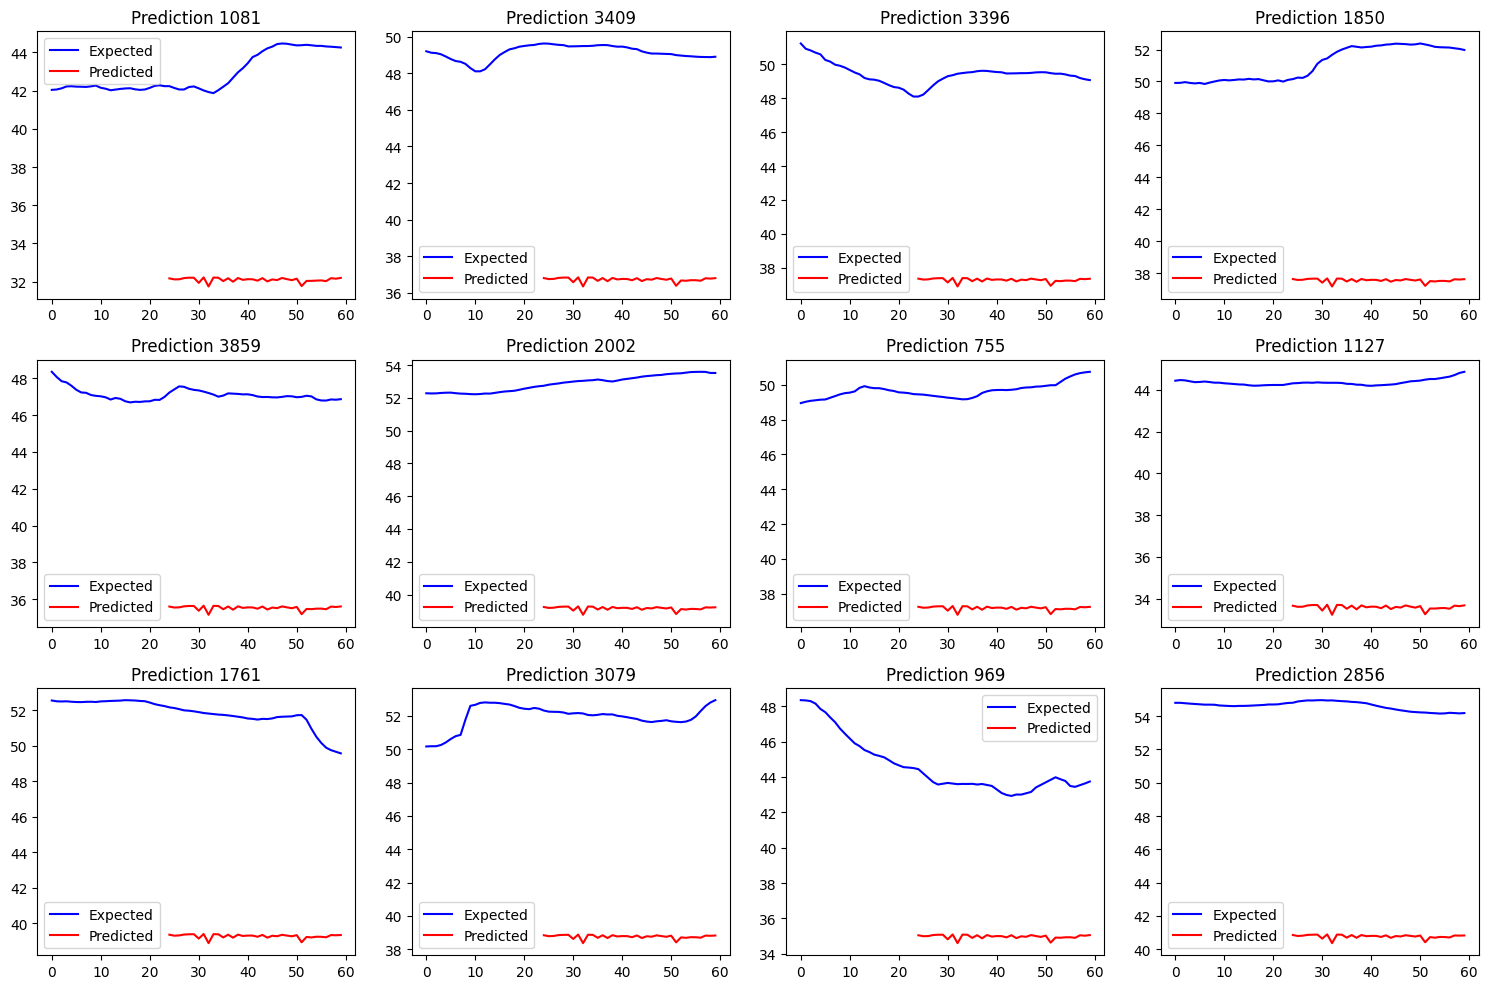

In [15]:
plot_random_predictions(model_baseline, test_dataset, N=12, COLS=4)

# Now that we have some benchmark, lets build the model


In [36]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[WINDOW_SIZE]),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.Conv1D(filters=3, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Conv1D(filters=3, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Conv1D(filters=3, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(TIMESTEPS_AHEAD),
    tf.keras.layers.Lambda(lambda x: x * 100)
])

model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_8 (Lambda)           (None, 24, 1)             0         
                                                                 
 conv1d_13 (Conv1D)          (None, 24, 3)             12        
                                                                 
 conv1d_14 (Conv1D)          (None, 24, 3)             30        
                                                                 
 conv1d_15 (Conv1D)          (None, 24, 3)             30        
                                                                 
 flatten_4 (Flatten)         (None, 72)                0         
                                                                 
 dropout_18 (Dropout)        (None, 72)                0         
                                                                 
 dense_17 (Dense)            (None, 10)               

In [37]:
model1.compile(loss = tf.losses.MeanSquaredError(),
               optimizer = "adam",
               metrics   = ["mae", "mse"])

#patience callback of 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, mode='min')

# Train the model and save the history
history = model1.fit(train_dataset,
                     epochs=EPOCHS,
                     validation_data=test_dataset,
                     callbacks=[early_stopping])

# Plot the loss and the MAE
fig = go.Figure()
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], mode='lines', name='Test'))
fig.update_layout(title='Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

Epoch 1/100


171/171 [==============================] - 3s 8ms/step - loss: 1154.9944 - mae: 26.0982 - mse: 1154.9944 - val_loss: 107.7101 - val_mae: 8.3018 - val_mse: 107.7101
Epoch 2/100
171/171 [==============================] - 1s 6ms/step - loss: 193.2977 - mae: 10.5727 - mse: 193.2977 - val_loss: 31.3714 - val_mae: 5.0296 - val_mse: 31.3714
Epoch 3/100
171/171 [==============================] - 1s 6ms/step - loss: 110.9286 - mae: 8.0449 - mse: 110.9286 - val_loss: 35.2795 - val_mae: 5.4571 - val_mse: 35.2795
Epoch 4/100
171/171 [==============================] - 1s 6ms/step - loss: 75.8991 - mae: 6.6906 - mse: 75.8991 - val_loss: 22.2464 - val_mae: 4.1366 - val_mse: 22.2464
Epoch 5/100
171/171 [==============================] - 1s 6ms/step - loss: 57.4777 - mae: 5.8622 - mse: 57.4777 - val_loss: 33.7028 - val_mae: 5.2467 - val_mse: 33.7028
Epoch 6/100
171/171 [==============================] - 1s 6ms/step - loss: 44.8500 - mae: 5.1773 - mse: 44.8500 - val_loss: 34.6404 - val_mae: 5.3069 - val

      1/Unknown - 0s 42ms/step - loss: 2.1883 - mae: 1.4056 - mse: 2.1883

130/130 [==============================] - 1s 4ms/step


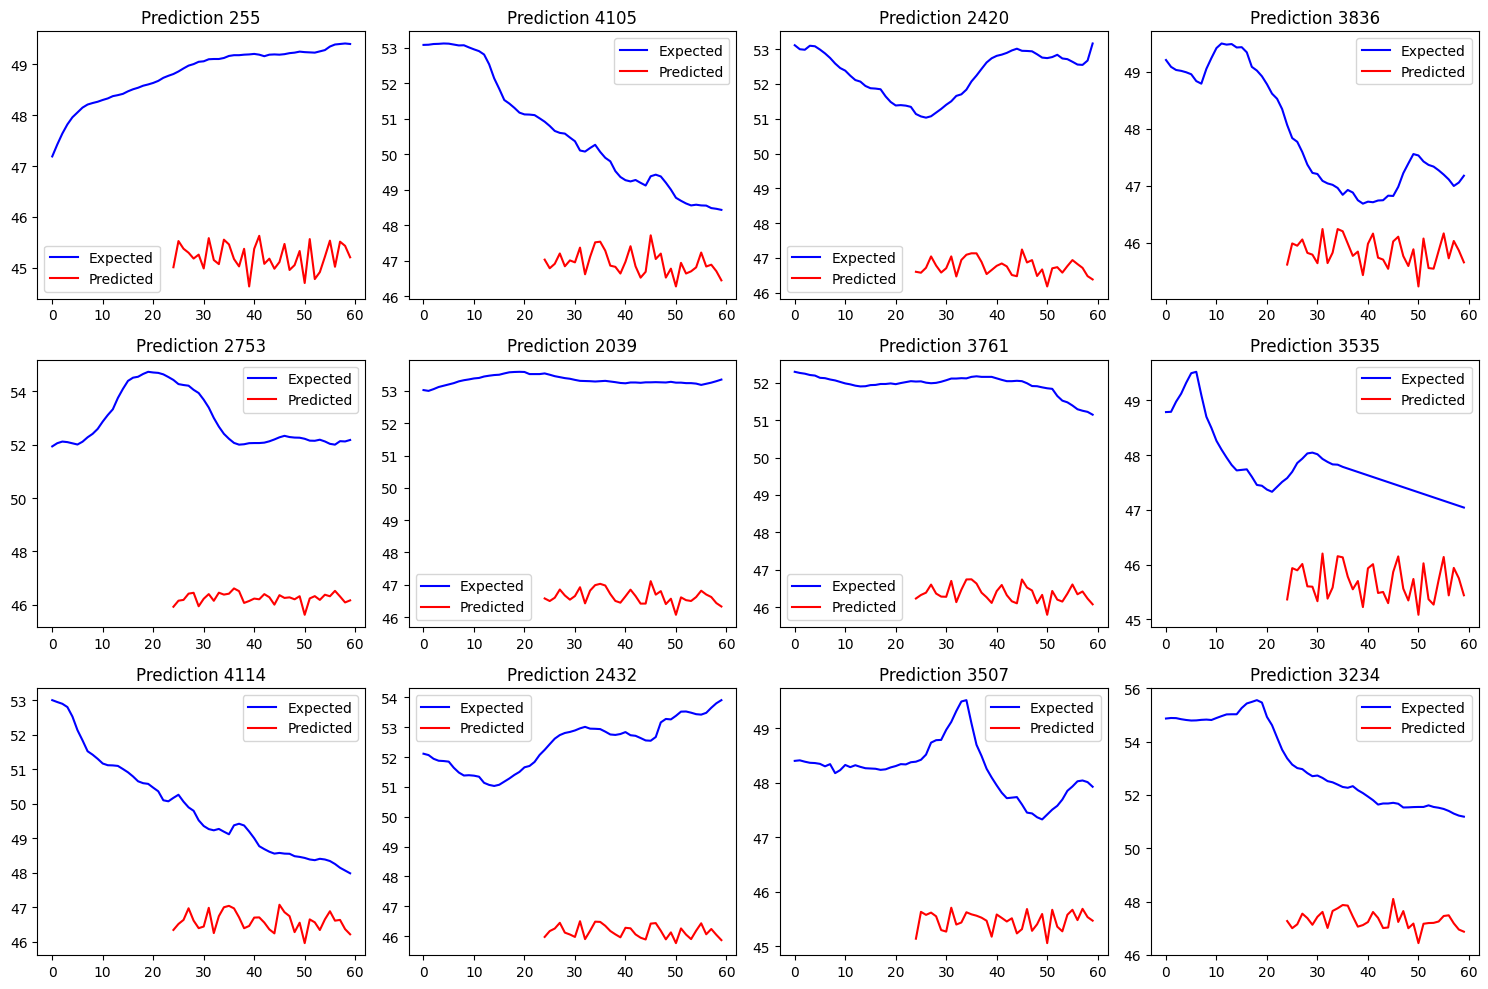

In [38]:
model1_eval = model1.evaluate(test_dataset)
plot_random_predictions(model1, test_dataset, N=12, COLS=4)

In [39]:
print(f"Baseline model: {baseline_eval}")
print(f"Model 1: {model1_eval}")

Baseline model: [158.77000427246094, 12.472402572631836, 158.77000427246094]
Model 1: [25.220062255859375, 4.39609956741333, 25.220062255859375]


# Create a more complex model

In [53]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[WINDOW_SIZE]),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.Conv1D(filters=3, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Conv1D(filters=3, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Conv1D(filters=3, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.GRU(10, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(TIMESTEPS_AHEAD),
    tf.keras.layers.Lambda(lambda x: x * 100)
])

ValueError: Input 0 of layer "gru_2" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 72)

In [52]:
model2.compile(loss = tf.losses.MeanSquaredError(),
               optimizer = "adam",
               metrics   = ["mae", "mse"])

#patience callback of 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, mode='min')

# Train the model and save the history
history = model2.fit(train_dataset,
                     epochs=EPOCHS,
                     validation_data=test_dataset,
                     callbacks=[early_stopping])

# Plot the loss and the MAE
fig = go.Figure()
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], mode='lines', name='Test'))
fig.update_layout(title='Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node mean_squared_error/SquaredDifference defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_906201/1629876632.py", line 9, in <module>

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call

  File "/home/dave/Documents/newmaticas/maticas-AI/.venv/lib/python3.11/site-packages/keras/src/losses.py", line 1706, in mean_squared_error

Incompatible shapes: [32,36] vs. [32,24,36]
	 [[{{node mean_squared_error/SquaredDifference}}]] [Op:__inference_train_function_215201]

In [ ]:
model2_eval = model2.evaluate(test_dataset)
plot_random_predictions(model2, test_dataset, N=12, COLS=4)

In [ ]:
print(f"Baseline model: {baseline_eval}")
print(f"Model 1: {model1_eval}")
print(f"Model 2: {model2_eval}")